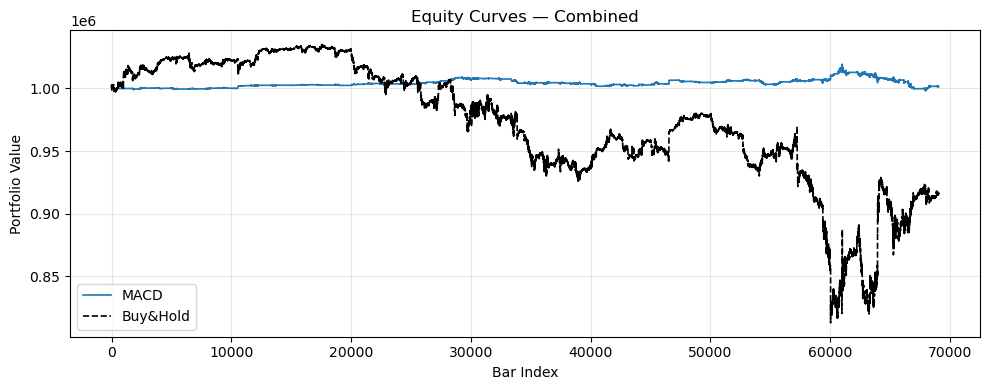

          Sharpe  MaxDD  Trades  %MomentumBars  Final(MACD)  Final(BH)
File                                                                  
Combined     0.0 -0.021    1846         44.236   1001293.25   916166.0


In [1]:
# ── intraday_compare_MACD.py ────────────────────────────────────
"""
Minute-ES back-tester: **MACD vs Buy-&-Hold** only
--------------------------------------------------
• Same ATR sizing, stop/target, volatility filter (high-vol only)
• One equity-curve plot per file
• Summary table with Sharpe, MaxDD, Trades, %Momentum/%Swing bars
"""

from __future__ import annotations
import datetime as dt, re, math
from pathlib import Path
from typing import List, Optional, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── CONFIG ──────────────────────────────────────────────────────
FILES = {
    "Combined": Path("combined_all_three.csv")  # match RSI and Stoch input
}


VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW    = 1.1, 0.9           # momentum / swing cut-offs
CASH0, RISK_PCT      = 1_000_000, 0.2
MAX_QTY, FEE         = 500, 0
STOP_ATR, TARGET_ATR = 1.5,3         # 2-to-1 reward-risk

# ── 1. Parsers ──────────────────────────────────────────────────
_DATE = re.compile(r"(\d{2}[A-Z]{3}\d{4})_")

def parse_intraday(p: Path) -> pd.DataFrame:
    rows, cur = [], None
    with p.open() as fh:
        for ln in fh:
            ln = ln.strip()
            if not ln: continue
            if m := _DATE.match(ln):
                cur = dt.datetime.strptime(m[1], "%d%b%Y").date(); continue
            if ln.startswith(("Time Interval","Summary")) or cur is None: continue
            if "-" in ln.split(";",1)[0]:
                cols = ln.split(";")[:8]
                h, mi = map(int, cols[0].split("-",1)[0].split(":"))
                ts = dt.datetime.combine(cur, dt.time(h, mi))
                vals = [float(x.replace(",",".")) if x else np.nan for x in cols[1:8]]
                rows.append([ts]+vals)
    df = pd.DataFrame(rows, columns=["ts","close","_","open","high","low","_t","vol"]).set_index("ts")
    return df[["open","high","low","close","vol"]]

def parse_combined(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p, parse_dates=["timestamp"]).set_index("timestamp")
    return df[["open","high","low","close","volume"]]

def load_file(p: Path) -> pd.DataFrame:
    return parse_combined(p) if p.name.startswith("combined") else parse_intraday(p)

# ── 2. Indicators ───────────────────────────────────────────────
def add_ind(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # ATR
    d["TR"]  = pd.concat([d.high-d.low,
                          (d.high-d.close.shift()).abs(),
                          (d.low -d.close.shift()).abs()],axis=1).max(axis=1)
    d["ATR"] = d.TR.rolling(14).mean()
    # MACD
    d["MACD"]     = d.close.ewm(12).mean() - d.close.ewm(26).mean()
    d["MACD_sig"] = d.MACD.ewm(9).mean()
    d["Signal_MACD"] = np.where(d.MACD>d.MACD_sig, 1, -1)
    # Vol ratio
    lr = np.log(d.close/d.close.shift())
    d["vol"]      = lr.rolling(VOL_WIN).std()*np.sqrt(20)
    d["vol_med"]  = d.vol.rolling(VOL_MED_WIN).median()
    d["vr"]       = d.vol/d.vol_med
    return d

# ── 3. Helper metrics ───────────────────────────────────────────
def mdd(arr: List[float]) -> float:
    a = np.array(arr); peak = np.maximum.accumulate(a)
    return float(((a-peak)/peak).min())

def sharpe(arr: List[float]) -> float:
    r = pd.Series(arr).pct_change().dropna()
    return float(r.mean()/r.std()) if r.std() else np.nan

# ── 4. Position sizing & back-test ──────────────────────────────
def _qty(price: float, cash: float, vr: float) -> int:
    if math.isnan(vr) or vr==0: vr=1.0
    return min(MAX_QTY, int((cash*RISK_PCT)/(price*vr)))

def backtest_macd(df: pd.DataFrame) -> Tuple[List[float], int, int]:
    cash, pos = CASH0, 0
    eq, trades = [], 0
    entry = sl = tp = None
    mom_bars = 0
    for price, atr, vr, sig in zip(df.close, df.ATR, df.vr, df.Signal_MACD):
        high = vr >= THR_HIGH
        if high: mom_bars += 1
        # ---------- exit ----------
        if pos>0 and (price>=tp or price<=sl):
            cash += pos*price - FEE; pos=0
        elif pos<0 and (price<=tp or price>=sl):
            cash -= (-pos)*price + FEE; pos=0
        # ---------- entry (momentum only) ----------
        if pos==0 and high and sig!=0 and not math.isnan(atr):
            q = _qty(price, cash, vr)
            if q:
                trades +=1
                if sig==1:
                    cash-=q*price+FEE; pos= q
                    sl=price-STOP_ATR*atr; tp=price+TARGET_ATR*atr
                else:
                    cash+=q*price-FEE; pos=-q
                    sl=price+STOP_ATR*atr; tp=price-TARGET_ATR*atr
        eq.append(cash if pos==0 else cash+pos*price)
    return eq, trades, mom_bars

def buy_hold(df: pd.DataFrame)->List[float]:
    p0=df.close.iloc[0]; qty=int(CASH0//p0)
    cash=CASH0-qty*p0
    return (cash+qty*df.close).tolist()

# ── 5. Run & plot ───────────────────────────────────────────────
def run():
    rows=[]
    for name, path in FILES.items():
        df = add_ind(load_file(path))

        eq_macd, trades, mom = backtest_macd(df)
        eq_bh   = buy_hold(df)


        plt.figure(figsize=(10,4))
        plt.plot(eq_macd, label="MACD", lw=1.2)
        plt.plot(eq_bh,   label="Buy&Hold", ls="--", lw=1.2, c = "black")
        plt.title(f"Equity Curves — {name}")
        plt.xlabel("Bar Index"); plt.ylabel("Portfolio Value")
        plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

        rows.append({
            "File":   name,
            "Sharpe": sharpe(eq_macd),
            "MaxDD":  mdd(eq_macd),
            "Trades": trades,
            "%MomentumBars": mom/len(df)*100,
            "Final(MACD)": eq_macd[-1],
            "Final(BH)":   eq_bh[-1],
        })

    print(pd.DataFrame(rows).set_index("File").round(3))

if __name__ == "__main__":
    run()


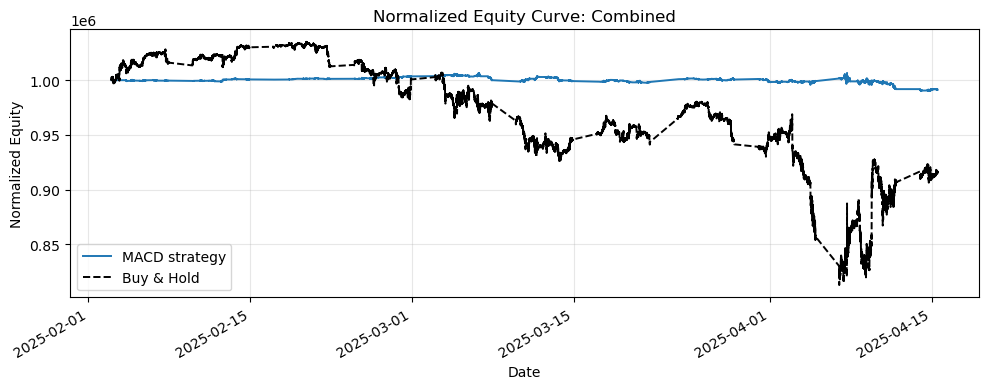

          Sharpe  MaxDD  Trades  %MomentumBars  Final(MACD)  Final(BH)
File                                                                  
Combined  -0.002 -0.016    1428         44.236     991260.5   916166.0


In [3]:
# ── intraday_compare_MACD.py ────────────────────────────────────
"""
Minute-ES back-tester: **MACD vs Buy-&-Hold** only
--------------------------------------------------
• Same ATR sizing, stop/target, volatility filter (high-vol only)
• One equity-curve plot per file
• Summary table with Sharpe, MaxDD, Trades, %Momentum/%Swing bars
"""

from __future__ import annotations
import datetime as dt, re, math
from pathlib import Path
from typing import List, Optional, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── CONFIG ──────────────────────────────────────────────────────
FILES = {
    "Combined": Path("combined_all_three.csv")  # match RSI and Stoch input
}


VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW    = 1.1, 0.9           # momentum / swing cut-offs
CASH0, RISK_PCT      = 1_000_000, 0.2
MAX_QTY, FEE         = 500, 0
STOP_ATR, TARGET_ATR = 2,3         # 2-to-1 reward-risk

# ── 1. Parsers ──────────────────────────────────────────────────
_DATE = re.compile(r"(\d{2}[A-Z]{3}\d{4})_")

def parse_intraday(p: Path) -> pd.DataFrame:
    rows, cur = [], None
    with p.open() as fh:
        for ln in fh:
            ln = ln.strip()
            if not ln: continue
            if m := _DATE.match(ln):
                cur = dt.datetime.strptime(m[1], "%d%b%Y").date(); continue
            if ln.startswith(("Time Interval","Summary")) or cur is None: continue
            if "-" in ln.split(";",1)[0]:
                cols = ln.split(";")[:8]
                h, mi = map(int, cols[0].split("-",1)[0].split(":"))
                ts = dt.datetime.combine(cur, dt.time(h, mi))
                vals = [float(x.replace(",",".")) if x else np.nan for x in cols[1:8]]
                rows.append([ts]+vals)
    df = pd.DataFrame(rows, columns=["ts","close","_","open","high","low","_t","vol"]).set_index("ts")
    return df[["open","high","low","close","vol"]]

def parse_combined(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p, parse_dates=["timestamp"]).set_index("timestamp")
    return df[["open","high","low","close","volume"]]

def load_file(p: Path) -> pd.DataFrame:
    return parse_combined(p) if p.name.startswith("combined") else parse_intraday(p)

# ── 2. Indicators ───────────────────────────────────────────────
def add_ind(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # ATR
    d["TR"]  = pd.concat([d.high-d.low,
                          (d.high-d.close.shift()).abs(),
                          (d.low -d.close.shift()).abs()],axis=1).max(axis=1)
    d["ATR"] = d.TR.rolling(14).mean()
    # MACD
    d["MACD"]     = d.close.ewm(6).mean() - d.close.ewm(32).mean()
    d["MACD_sig"] = d.MACD.ewm(4).mean()
    d["Signal_MACD"] = np.where(d.MACD>d.MACD_sig, 1, -1)
    # Vol ratio
    lr = np.log(d.close/d.close.shift())
    d["vol"]      = lr.rolling(VOL_WIN).std()*np.sqrt(20)
    d["vol_med"]  = d.vol.rolling(VOL_MED_WIN).median()
    d["vr"]       = d.vol/d.vol_med
    return d

# ── 3. Helper metrics ───────────────────────────────────────────
def mdd(arr: List[float]) -> float:
    a = np.array(arr); peak = np.maximum.accumulate(a)
    return float(((a-peak)/peak).min())

def sharpe(arr: List[float]) -> float:
    r = pd.Series(arr).pct_change().dropna()
    return float(r.mean()/r.std()) if r.std() else np.nan

# ── 4. Position sizing & back-test ──────────────────────────────
def _qty(price: float, cash: float, vr: float) -> int:
    if math.isnan(vr) or vr==0: vr=1.0
    return min(MAX_QTY, int((cash*RISK_PCT)/(price*vr)))

def backtest_macd(df: pd.DataFrame) -> Tuple[List[float], int, int]:
    cash, pos = CASH0, 0
    eq, trades = [], 0
    entry = sl = tp = None
    mom_bars = 0
    for price, atr, vr, sig in zip(df.close, df.ATR, df.vr, df.Signal_MACD):
        high = vr >= THR_HIGH
        if high: mom_bars += 1
        # ---------- exit ----------
        if pos>0 and (price>=tp or price<=sl):
            cash += pos*price - FEE; pos=0
        elif pos<0 and (price<=tp or price>=sl):
            cash -= (-pos)*price + FEE; pos=0
        # ---------- entry (momentum only) ----------
        if pos==0 and high and sig!=0 and not math.isnan(atr):
            q = _qty(price, cash, vr)
            if q:
                trades +=1
                if sig==1:
                    cash-=q*price+FEE; pos= q
                    sl=price-STOP_ATR*atr; tp=price+TARGET_ATR*atr
                else:
                    cash+=q*price-FEE; pos=-q
                    sl=price+STOP_ATR*atr; tp=price-TARGET_ATR*atr
        eq.append(cash if pos==0 else cash+pos*price)
    return eq, trades, mom_bars

def buy_hold(df: pd.DataFrame)->List[float]:
    p0=df.close.iloc[0]; qty=int(CASH0//p0)
    cash=CASH0-qty*p0
    return (cash+qty*df.close).tolist()
import matplotlib.dates as mdates  # put this once with your other imports

# ── 5. Run & plot ───────────────────────────────────────────────
def run():
    rows = []
    for name, path in FILES.items():
        df = add_ind(load_file(path))

        eq_macd, trades, mom = backtest_macd(df)
        eq_bh                 = buy_hold(df)

        # ── nicer date-based equity curve ───────────────────────
        fig, ax = plt.subplots(figsize=(10, 4))

        ax.plot(df.index, eq_macd, label="MACD strategy", lw=1.4)
        ax.plot(df.index, eq_bh,   label="Buy & Hold",    lw=1.4,
                ls="--", color="black")

        ax.set_title(f"Normalized Equity Curve: {name}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Normalized Equity")
        ax.grid(alpha=.3)
        ax.legend()

        fig.autofmt_xdate()      # slight rotation / spacing
        fig.tight_layout()
        plt.show()

        # collect period metrics (unchanged)
        rows.append({
            "File":   name,
            "Sharpe": sharpe(eq_macd),
            "MaxDD":  mdd(eq_macd),
            "Trades": trades,
            "%MomentumBars": mom / len(df) * 100,
            "Final(MACD)": eq_macd[-1],
            "Final(BH)":   eq_bh[-1],
        })

    print(pd.DataFrame(rows).set_index("File").round(3))

if __name__ == "__main__":
    run()



===== Combined =====


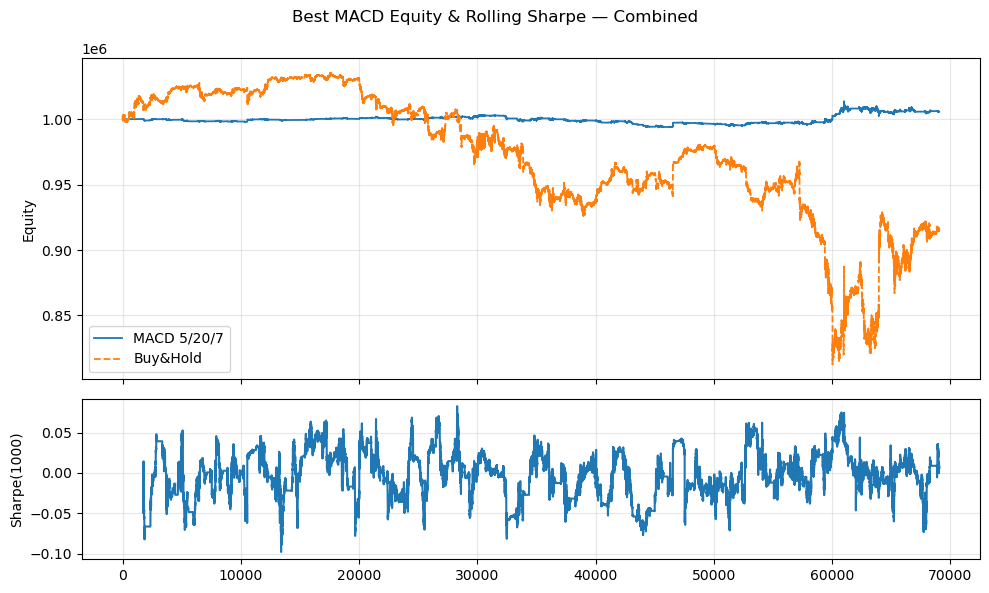

 fast  slow  sig  Sharpe  MaxDD  WinRate%  Trades      Final
    5    20    7   0.001 -0.011    34.981    1801 1005668.00
    3    15    5  -0.001 -0.015    34.800    1750  997341.75
    8    26    9  -0.001 -0.020    35.808    1832  995929.75
    2     8    4  -0.006 -0.025    34.065    1776  976031.75


In [4]:
# ── intraday_compare_MACD_OPT.py ─────────────────────────────────
"""
MACD optimiser: tests many (fast, slow, signal) triplets and reports
Sharpe, Max-DD, Win-rate.  Keeps all other assumptions (high-vol gate,
20 % risk, 1.5 / 3 ATR stops).
"""

from __future__ import annotations
import datetime as dt, re, math
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ╭──────────────── CONFIG ─────────────────╮
FILES = {
    "Combined": Path("combined_all_three.csv")  # match RSI and Stoch input
}


# ► ► put every MACD trio you want to test here
MACD_PARAM_GRID: List[Tuple[int,int,int]] = [
    (2,  8,  4),
    (3, 15,  5),
    (5, 20,  7),
    (8, 26,  9),
]

VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW    = 1.1, 0.9 
CASH0,  RISK_PCT     = 1_000_000, 0.20
MAX_QTY, FEE         = 500, 0
STOP_ATR, TARGET_ATR = 1.5, 3.0
ROLL_WIN             = 1_000           # for rolling Sharpe plot

# ╭──────────────── PARSERS (unchanged) ───────────────╮
_DATE = re.compile(r"(\d{2}[A-Z]{3}\d{4})_")
def parse_intraday(p: Path) -> pd.DataFrame:
    rows, cur = [], None
    with p.open() as fh:
        for ln in fh:
            ln = ln.strip();   
            if not ln: continue
            if m := _DATE.match(ln):
                cur = dt.datetime.strptime(m[1],"%d%b%Y").date(); continue
            if ln.startswith(("Time Interval","Summary")) or cur is None: continue
            if "-" in ln.split(";",1)[0]:
                c = ln.split(";")[:8]
                h,mi = map(int,c[0].split("-",1)[0].split(":"))
                ts   = dt.datetime.combine(cur, dt.time(h,mi))
                vals = [float(x.replace(",",".")) if x else np.nan for x in c[1:8]]
                rows.append([ts]+vals)
    df = pd.DataFrame(rows, columns=["ts","close","_","open","high","low","_t","vol"]).set_index("ts")
    return df[["open","high","low","close","vol"]]

def parse_combined(p: Path) -> pd.DataFrame:
    return (pd.read_csv(p, parse_dates=["timestamp"])
              .set_index("timestamp")[["open","high","low","close","volume"]])

def load_file(p: Path) -> pd.DataFrame:
    return parse_combined(p) if p.name.startswith("combined") else parse_intraday(p)

# ╭──────────────── INDICATORS (param-aware) ──────────╮
def add_ind(df: pd.DataFrame, fast:int, slow:int, sig:int) -> pd.DataFrame:
    d = df.copy()
    # ATR
    tr = pd.concat([d.high-d.low,
                    (d.high-d.close.shift()).abs(),
                    (d.low -d.close.shift()).abs()],axis=1).max(axis=1)
    d["ATR"] = tr.rolling(14).mean()
    # MACD
    d["MACD"]     = d.close.ewm(fast).mean() - d.close.ewm(slow).mean()
    d["MACD_sig"] = d.MACD.ewm(sig).mean()
    d["Signal_MACD"] = np.where(d.MACD>d.MACD_sig, 1, -1)
    # Vol ratio
    lr = np.log(d.close/d.close.shift())
    d["vol"]      = lr.rolling(VOL_WIN).std()*np.sqrt(20)
    d["vol_med"]  = d.vol.rolling(VOL_MED_WIN).median()
    d["vr"]       = d.vol/d.vol_med
    return d

# ╭──────────────── Metrics helpers ───────────────────╮
def mdd(a): a=np.array(a); peak=np.maximum.accumulate(a); return float(((a-peak)/peak).min())
def sharpe(a): r=pd.Series(a).pct_change().dropna(); return float(r.mean()/r.std()) if r.std() else np.nan
def _qty(price,cash,vr): vr=vr or 1.0; return min(MAX_QTY,int((cash*RISK_PCT)/(price*vr)))

# ╭──────────────── Back-test with regime gate ─────────────────╮
def backtest(df: pd.DataFrame,
             need_reg: str = "high"     # "high", "low", or "all"
            ) -> Tuple[List[float], List[float]]:
    """
    Executes a MACD strategy on one DataFrame and returns
    (equity_curve, list_of_trade_PnLs).

    need_reg = "high" → trade only when vr ≥ THR_HIGH
    need_reg = "low"  → trade only when vr ≤ THR_LOW
    need_reg = "all"  → ignore volatility filter
    """
    cash, pos = CASH0, 0
    equity, pnl = [], []
    entry = stop = target = None

    for price, atr, vr, sig in zip(df.close, df.ATR, df.vr, df.Signal_MACD):

        # ── regime gate ───────────────────────────────────────────
        high = vr >= THR_HIGH
        low  = vr <= THR_LOW
        if   need_reg == "high" and not high:
            sig = 0          # skip bar
        elif need_reg == "low"  and not low:
            sig = 0
        # need_reg == "all" → keep original sig

        # ── exits ────────────────────────────────────────────────
        if pos > 0 and (price >= target or price <= stop):
            cash += pos * price - FEE
            pnl.append((price - entry) * pos - FEE)
            pos = 0
        elif pos < 0 and (price <= target or price >= stop):
            cash -= (-pos) * price + FEE
            pnl.append((entry - price) * (-pos) - FEE)
            pos = 0

        # ── entries ──────────────────────────────────────────────
        if pos == 0 and sig != 0 and not np.isnan(atr):
            qty = _qty(price, cash, vr)
            if qty:
                entry = price
                if sig == 1:                                  # long
                    cash -= qty * price + FEE
                    pos   =  qty
                    stop  = price - STOP_ATR * atr
                    target= price + TARGET_ATR * atr
                else:                                         # short
                    cash += qty * price - FEE
                    pos   = -qty
                    stop  = price + STOP_ATR * atr
                    target= price - TARGET_ATR * atr

        # ── mark-to-market equity ───────────────────────────────
        equity.append(cash if pos == 0 else cash + pos * price)

    return equity, pnl, len(pnl)


def buy_hold(df): p0=df.close.iloc[0]; qty=int(CASH0//p0); cash=CASH0-qty*p0; return (cash+qty*df.close).tolist()

# ╭──────────────── Runner ────────────────────────────╮
def run():
    for name, path in FILES.items():
        print(f"\n===== {name} =====")
        scores=[]
        best_eq=None; best_tag=""
        df_raw = load_file(path)

        for fast,slow,sig in MACD_PARAM_GRID:
            df = add_ind(df_raw, fast, slow, sig)
            eq, pnl, n_trades = backtest(df)
            scores.append({
            "fast":fast,"slow":slow,"sig":sig,
            "Sharpe":sharpe(eq),
            "MaxDD": mdd(eq),
            "WinRate%": (np.array(pnl)>0).mean()*100 if pnl else np.nan,
            "Trades": n_trades,
            "Final": eq[-1]
        })
            # store best by Sharpe
            if best_eq is None or scores[-1]["Sharpe"] > max(s["Sharpe"] for s in scores[:-1]):
                best_eq, best_tag = eq, f"MACD {fast}/{slow}/{sig}"

        # plot best vs buy&hold
        eq_bh = buy_hold(add_ind(df_raw,3,15,5))  # BH needs only prices
        fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,6),sharex=True,height_ratios=[2,1])

        ax1.plot(best_eq,label=best_tag,lw=1.3)
        ax1.plot(eq_bh,label="Buy&Hold",ls="--",lw=1.3)
        ax1.set_ylabel("Equity"); ax1.legend(); ax1.grid(alpha=.3)


        ret = pd.Series(best_eq).pct_change()
        roll = (ret.rolling(ROLL_WIN).mean()/ret.rolling(ROLL_WIN).std())
        ax2.plot(roll,label="Rolling Sharpe")
        ax2.set_ylabel(f"Sharpe({ROLL_WIN})"); ax2.grid(alpha=.3)
        plt.suptitle(f"Best MACD Equity & Rolling Sharpe — {name}")
        plt.tight_layout(); plt.show()

        # show scoreboard
        df_score = (pd.DataFrame(scores)
                    .sort_values("Sharpe",ascending=False)
                    .reset_index(drop=True)
                    .round(3))
        print(df_score.to_string(index=False))

if __name__ == "__main__":
    run()


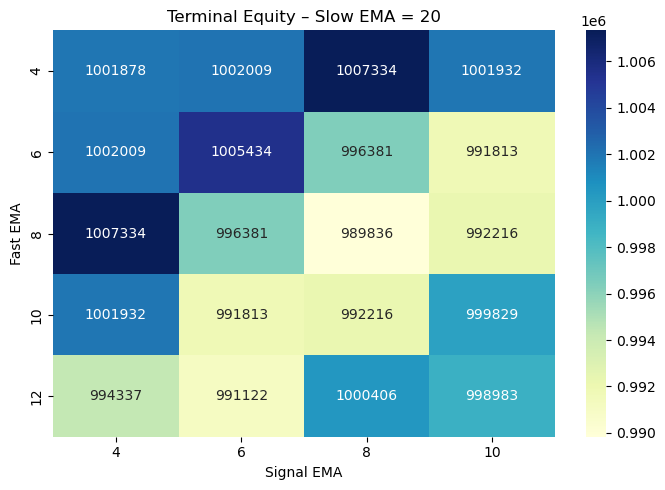

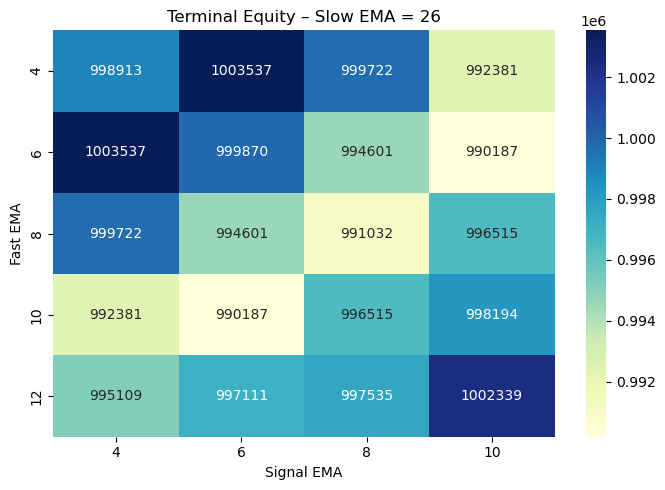

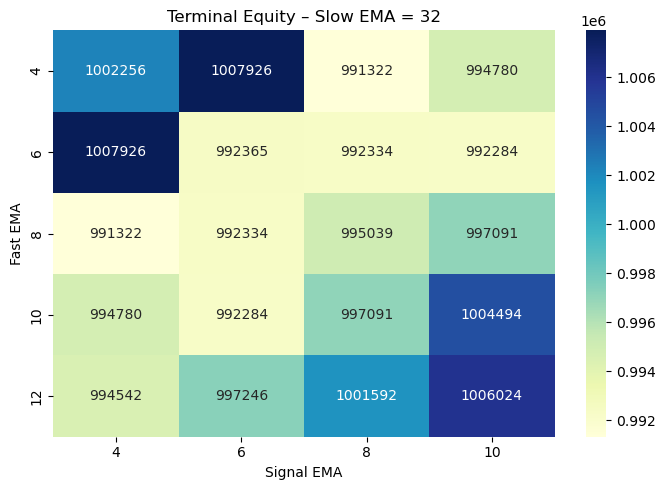


Top-10 MACD parameter combinations sorted by final equity

    Fast  Slow  Signal     Equity  Trades  Win Rate (%)  Swing (%)  Momentum (%)
1      6    32       4  1007926.0    1810          35.4       47.8          52.2
2      4    32       6  1007926.0    1810          35.4       47.8          52.2
3      4    20       8  1007334.0    1808          35.1       47.8          52.2
4      8    20       4  1007334.0    1808          35.1       47.8          52.2
5     12    32      10  1006024.0    1845          36.5       47.8          52.2
6      6    20       6  1005434.0    1801          35.0       47.8          52.2
7     10    32      10  1004494.0    1853          36.0       47.8          52.2
8      4    26       6  1003537.0    1810          34.5       47.8          52.2
9      6    26       4  1003537.0    1810          34.5       47.8          52.2
10    12    26      10  1002339.0    1838          35.7       47.8          52.2


In [6]:
# ░░░  MACD grid scan – “MACD-vs-BH” rules  ░░░
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings, re, datetime as dt
from pathlib import Path
warnings.filterwarnings("ignore")

# ── CONFIG ──────────────────────────────────────────────────────
FILE = Path("combined_all_three.csv")  # ✅ Matches RSI & Stochastic code

FAST_LIST   = [4, 6, 8, 10, 12]        # EMA fast spans
SLOW_LIST   = [20, 26, 32]             # EMA slow spans (must be > fast)
SIGNAL_LIST = [4, 6, 8, 10]            # Signal-line spans

VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW    = 1.10, 0.90
CASH0,  RISK_PCT     = 1_000_000, 0.20
MAX_QTY, FEE         = 500, 0
STOP_ATR, TARGET_ATR = 1.5, 3.0

# ── 0. Loader ───────────────────────────────────────────────────
def parse_file(p: Path) -> pd.DataFrame:
    if p.name.startswith("combined"):
        return (pd.read_csv(p, parse_dates=["timestamp"])
                  .set_index("timestamp")
                  [["open","high","low","close","volume"]])
    raise ValueError("Unsupported file type")

source_df = parse_file(FILE)  # ✅ FIXED: directly use FILE

# ── 1. Indicator factory ────────────────────────────────────────
VOL_RSQRT20 = np.sqrt(20)
def add_ind(df: pd.DataFrame, fast:int, slow:int, sig:int) -> pd.DataFrame:
    d = df.copy()
    tr = pd.concat([d.high-d.low,
                    (d.high-d.close.shift()).abs(),
                    (d.low -d.close.shift()).abs()], axis=1).max(axis=1)
    d["ATR"] = tr.rolling(14).mean()
    d["MACD"]     = d.close.ewm(fast).mean() - d.close.ewm(slow).mean()
    d["MACD_sig"] = d.MACD.ewm(sig).mean()
    d["Signal"]   = np.where(d.MACD > d.MACD_sig, 1, -1)
    lr  = np.log(d.close / d.close.shift())
    vol = lr.rolling(VOL_WIN).std() * VOL_RSQRT20
    d["vr"] = vol / vol.rolling(VOL_MED_WIN).median()
    return d

# ── 2. Sizing helper ────────────────────────────────────────────
def _qty(price, cash, vr):
    if np.isnan(vr) or vr == 0: vr = 1.0
    return min(MAX_QTY, int((cash * RISK_PCT) / (price * vr)))

# ── 3. Back-test ────────────────────────────────────────────────
def sim(df: pd.DataFrame):
    cash, pos = CASH0, 0
    entry = stop = tgt = None
    n_trades = wins = 0
    bar_mom = bar_sw = 0

    for price, atr, vr, sig in zip(df.close, df.ATR, df.vr, df.Signal):
        high = vr >= THR_HIGH
        low  = vr <= THR_LOW
        if high: bar_mom += 1
        if low:  bar_sw  += 1

        if pos > 0 and (price >= tgt or price <= stop):
            cash += pos * price - FEE
            wins += price >= tgt
            pos = 0
        elif pos < 0 and (price <= tgt or price >= stop):
            cash -= (-pos) * price - FEE
            wins += price <= tgt
            pos = 0

        if pos == 0 and high and sig != 0 and not np.isnan(atr):
            qty = _qty(price, cash, vr)
            if qty:
                n_trades += 1
                entry = price
                if sig == 1:
                    cash -= qty * price + FEE
                    pos = qty
                    stop = price - STOP_ATR * atr
                    tgt = price + TARGET_ATR * atr
                else:
                    cash += qty * price - FEE
                    pos = -qty
                    stop = price + STOP_ATR * atr
                    tgt = price - TARGET_ATR * atr

    final_eq = cash if pos == 0 else cash + pos * price
    tot = bar_mom + bar_sw or 1
    mom_pct = bar_mom / tot * 100
    sw_pct  = bar_sw / tot * 100
    win_pct = wins / n_trades * 100 if n_trades else 0
    return final_eq, n_trades, win_pct, mom_pct, sw_pct

# ── 4. Grid scan ─────────────────────────────────────────────────
records = []
for s in SLOW_LIST:
    for f in FAST_LIST:
        if f >= s: continue
        for m in SIGNAL_LIST:
            df_ind = add_ind(source_df, f, s, m)
            eq, trd, win, mom, sw = sim(df_ind)
            records.append(dict(Fast=f, Slow=s, Signal=m,
                                Equity=eq, Trades=trd,
                                WinRate=win, Momentum=mom, Swing=sw))

df_res = pd.DataFrame(records)

# ── 5. Heatmaps ─────────────────────────────────────────────────
for s in SLOW_LIST:
    piv = df_res[df_res.Slow == s].pivot(index="Fast", columns="Signal", values="Equity")
    plt.figure(figsize=(7,5))
    sns.heatmap(piv, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f"Terminal Equity – Slow EMA = {s}")
    plt.ylabel("Fast EMA"); plt.xlabel("Signal EMA")
    plt.tight_layout(); plt.show()

# ── 6. Top-10 Summary ───────────────────────────────────────────
top10 = (df_res.sort_values("Equity", ascending=False)
               .reset_index(drop=True)
               .head(10)
               .round({"Equity":0,"WinRate":1,"Momentum":1,"Swing":1}))
top10.index = np.arange(1, len(top10)+1)

print("\nTop-10 MACD parameter combinations sorted by final equity\n")
print(top10[["Fast","Slow","Signal","Equity",
             "Trades","WinRate","Swing","Momentum"]]
      .rename(columns={"WinRate":"Win Rate (%)",
                       "Swing":"Swing (%)",
                       "Momentum":"Momentum (%)"})
      .to_string())


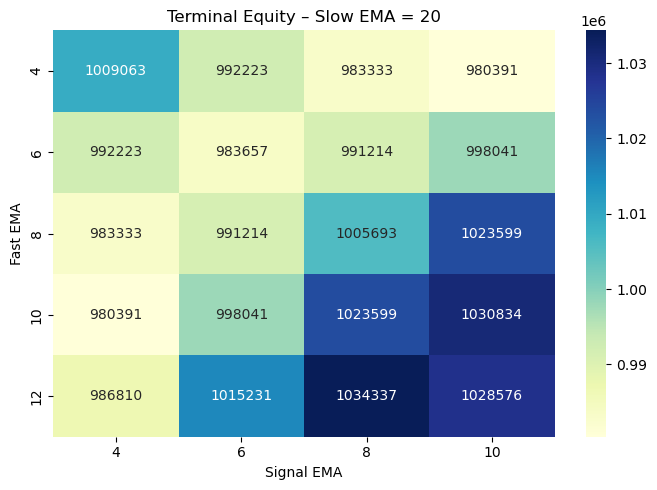

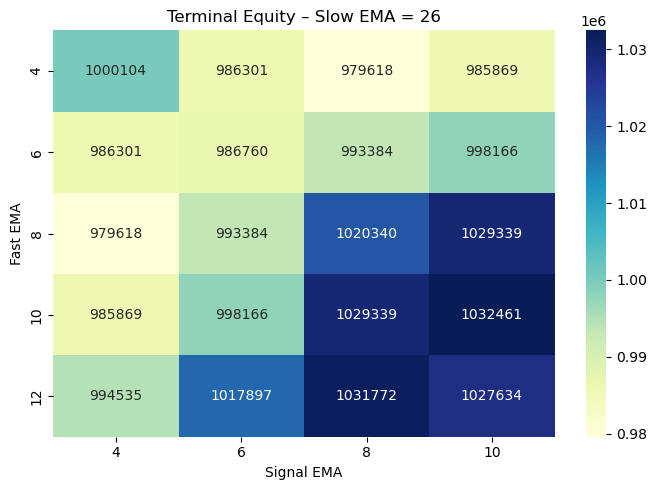

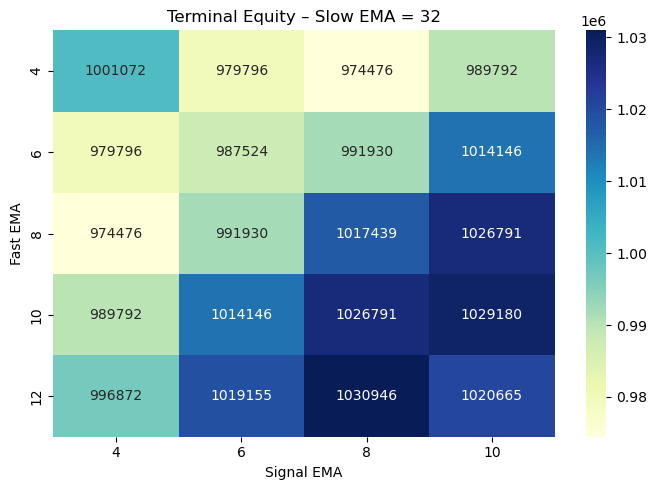


Top-10 MACD parameter combinations sorted by final equity

    Fast  Slow  Signal     Equity  Trades  Win Rate (%)  Swing (%)  Momentum (%)
1     12    20       8  1034337.0    3286          36.5       47.7          52.3
2     10    26      10  1032461.0    3307          36.0       47.6          52.4
3     12    26       8  1031772.0    3308          36.1       47.6          52.4
4     12    32       8  1030946.0    3313          35.9       47.6          52.4
5     10    20      10  1030834.0    3304          36.3       47.9          52.1
6     10    26       8  1029339.0    3284          36.3       47.9          52.1
7      8    26      10  1029339.0    3284          36.3       47.9          52.1
8     10    32      10  1029180.0    3318          35.8       47.5          52.5
9     12    20      10  1028576.0    3333          36.0       47.6          52.4
10    12    26      10  1027634.0    3330          35.7       47.5          52.5


In [8]:
# ░░░  MACD grid scan – “MACD-vs-BH” rules  ░░░
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings, re, datetime as dt
from pathlib import Path
warnings.filterwarnings("ignore")

# ── CONFIG ──────────────────────────────────────────────────────
FILE = Path("combined_all_three.csv")  # ✅ Correct single definition
FAST_LIST   = [4, 6, 8, 10, 12]
SLOW_LIST   = [20, 26, 32]
SIGNAL_LIST = [4, 6, 8, 10]

VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW    = 1.10, 0.90
CASH0,  RISK_PCT     = 1_000_000, 0.20
MAX_QTY, FEE         = 500, 0
STOP_ATR, TARGET_ATR = 1.5, 3.0

# ── 0. Loader ───────────────────────────────────────────────────
_DATE_RE = re.compile(r"(\d{2}[A-Z]{3}\d{4})_")

def parse_file(p: Path) -> pd.DataFrame:
    if p.name.startswith("combined"):
        return (pd.read_csv(p, parse_dates=["timestamp"])
                  .set_index("timestamp")
                  [["open", "high", "low", "close", "volume"]])
    raise ValueError("Unsupported file format.")

source_df = parse_file(FILE)

# ── 1. Indicator factory ────────────────────────────────────────
VOL_RSQRT20 = np.sqrt(20)

def add_ind(df: pd.DataFrame, fast: int, slow: int, sig: int) -> pd.DataFrame:
    d = df.copy()

    # ATR
    tr = pd.concat([
        d.high - d.low,
        (d.high - d.close.shift()).abs(),
        (d.low  - d.close.shift()).abs()
    ], axis=1).max(axis=1)
    d["ATR"] = tr.rolling(14).mean()

    # MACD and Signal
    d["MACD"]     = d.close.ewm(span=fast).mean() - d.close.ewm(span=slow).mean()
    d["MACD_sig"] = d.MACD.ewm(span=sig).mean()
    d["Signal"]   = np.where(d.MACD > d.MACD_sig, 1, -1)

    # Volatility Ratio
    lr = np.log(d.close / d.close.shift())
    vol = lr.rolling(VOL_WIN).std() * VOL_RSQRT20
    d["vr"] = vol / vol.rolling(VOL_MED_WIN).median()

    return d

# ── 2. Position Sizing ──────────────────────────────────────────
def _qty(price, cash, vr):
    if np.isnan(vr) or vr == 0: vr = 1.0
    return min(MAX_QTY, int((cash * RISK_PCT) / (price * vr)))

# ── 3. Back-test Logic ──────────────────────────────────────────
def sim(df: pd.DataFrame):
    cash, pos = CASH0, 0
    entry = stop = tgt = None
    n_trades = wins = 0
    mom_trd = sw_trd = 0

    for price, atr, vr, sig in zip(df.close, df.ATR, df.vr, df.Signal):
        high = vr >= THR_HIGH
        low  = vr <= THR_LOW

        # Exit logic
        if pos > 0 and (price >= tgt or price <= stop):
            cash += pos * price - FEE
            wins += price >= tgt
            pos = 0
        elif pos < 0 and (price <= tgt or price >= stop):
            cash -= (-pos) * price - FEE
            wins += price <= tgt
            pos = 0

        # Entry logic — momentum
        if pos == 0 and high and sig != 0 and not np.isnan(atr):
            qty = _qty(price, cash, vr)
            if qty == 0: continue
            n_trades += 1
            mom_trd += 1
            entry = price
            if sig == 1:
                cash -= qty * price + FEE
                pos = qty
                stop = price - STOP_ATR * atr
                tgt = price + TARGET_ATR * atr
            else:
                cash += qty * price - FEE
                pos = -qty
                stop = price + STOP_ATR * atr
                tgt = price - TARGET_ATR * atr

        # Entry logic — swing
        elif pos == 0 and low and sig != 0 and not np.isnan(atr):
            qty = _qty(price, cash, vr)
            if qty == 0: continue
            n_trades += 1
            sw_trd += 1
            entry = price
            if sig == 1:
                cash -= qty * price + FEE
                pos = qty
                stop = price - STOP_ATR * atr
                tgt = price + TARGET_ATR * atr
            else:
                cash += qty * price - FEE
                pos = -qty
                stop = price + STOP_ATR * atr
                tgt = price - TARGET_ATR * atr

    final_eq = cash if pos == 0 else cash + pos * price
    win_rate = wins / n_trades * 100 if n_trades else 0
    mom_pct  = mom_trd / n_trades * 100 if n_trades else 0
    sw_pct   = sw_trd  / n_trades * 100 if n_trades else 0
    return final_eq, n_trades, win_rate, mom_pct, sw_pct

# ── 4. Grid Scan ────────────────────────────────────────────────
records = []
for s in SLOW_LIST:
    for f in FAST_LIST:
        if f >= s: continue
        for m in SIGNAL_LIST:
            df_ind = add_ind(source_df, f, s, m)
            eq, trd, win, mom, sw = sim(df_ind)
            records.append(dict(Fast=f, Slow=s, Signal=m,
                                Equity=eq, Trades=trd,
                                WinRate=win, Momentum=mom, Swing=sw))

df_res = pd.DataFrame(records)

# ── 5. Heatmaps ─────────────────────────────────────────────────
for s in SLOW_LIST:
    pivot = df_res[df_res.Slow == s].pivot(index="Fast", columns="Signal", values="Equity")
    plt.figure(figsize=(7, 5))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f"Terminal Equity – Slow EMA = {s}")
    plt.ylabel("Fast EMA"); plt.xlabel("Signal EMA")
    plt.tight_layout(); plt.show()

# ── 6. Top-10 Table ─────────────────────────────────────────────
top10 = (df_res.sort_values("Equity", ascending=False)
         .reset_index(drop=True)
         .head(10)
         .round({"Equity": 0, "WinRate": 1, "Momentum": 1, "Swing": 1}))
top10.index = np.arange(1, len(top10)+1)

print("\nTop-10 MACD parameter combinations sorted by final equity\n")
print(top10[["Fast", "Slow", "Signal", "Equity", "Trades",
             "WinRate", "Swing", "Momentum"]]
      .rename(columns={
          "WinRate": "Win Rate (%)",
          "Swing": "Swing (%)",
          "Momentum": "Momentum (%)"
      })
      .to_string())


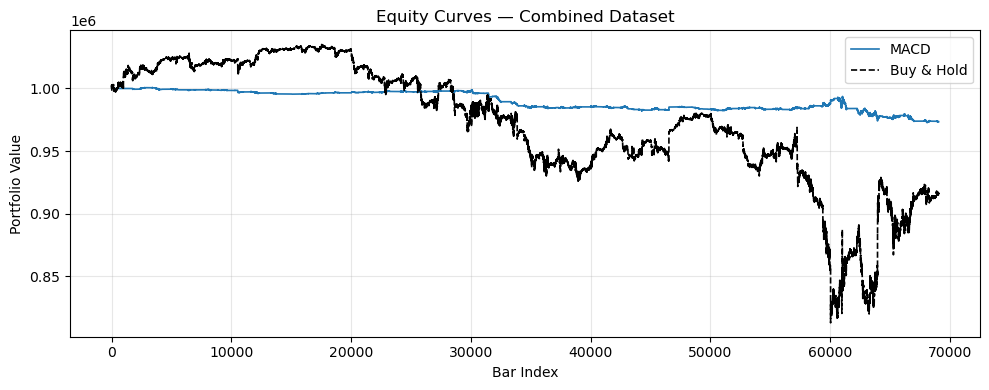

                 Combined
Sharpe             -0.007
MaxDD              -0.028
Trades           1797.000
%MomentumBars      44.236
Final(MACD)    973443.500
Final(BH)      916166.000


In [9]:
"""
MACD vs Buy-and-Hold: Intraday backtest
---------------------------------------
• Applies ATR-based stop/target and volatility regime filter
• Uses only combined_all_three.csv (same as RSI & Stoch)
• Plots equity curves and outputs summary stats
"""

import datetime as dt, math
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── CONFIG ─────────────────────────────────────────────────────
DATA_PATH = Path("combined_all_three.csv")  # ← unified file for all strategies

VOL_WIN, VOL_MED_WIN = 80, 1440
THR_HIGH, THR_LOW    = 1.1, 0.9
CASH0, RISK_PCT      = 1_000_000, 0.20
MAX_QTY, FEE         = 500, 0
STOP_ATR, TARGET_ATR = 1.5, 3.0

# ─── Load Data ──────────────────────────────────────────────────
def load_combined(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p, parse_dates=["timestamp"]).set_index("timestamp")
    return df[["open", "high", "low", "close", "volume"]]

# ─── Add Indicators ─────────────────────────────────────────────
def add_ind(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # ATR
    tr = pd.concat([
        d.high - d.low,
        (d.high - d.close.shift()).abs(),
        (d.low  - d.close.shift()).abs()
    ], axis=1).max(axis=1)
    d["ATR"] = tr.rolling(14).mean()
    # MACD
    d["MACD"]     = d.close.ewm(span=6).mean() - d.close.ewm(span=32).mean()
    d["MACD_sig"] = d["MACD"].ewm(span=4).mean()
    d["Signal_MACD"] = np.where(d.MACD > d.MACD_sig, 1, -1)
    # Volatility Ratio
    lr = np.log(d.close / d.close.shift())
    d["vol"] = lr.rolling(VOL_WIN).std() * np.sqrt(20)
    d["vol_med"] = d.vol.rolling(VOL_MED_WIN).median()
    d["vr"] = d.vol / d.vol_med
    return d

# ─── Metrics ────────────────────────────────────────────────────
def mdd(arr: List[float]) -> float:
    a = np.array(arr)
    peak = np.maximum.accumulate(a)
    return float(((a - peak) / peak).min())

def sharpe(arr: List[float]) -> float:
    r = pd.Series(arr).pct_change().dropna()
    return float(r.mean() / r.std()) if r.std() else np.nan

# ─── Backtest Logic ─────────────────────────────────────────────
def _qty(price: float, cash: float, vr: float) -> int:
    if math.isnan(vr) or vr == 0: vr = 1.0
    return min(MAX_QTY, int((cash * RISK_PCT) / (price * vr)))

def backtest_macd(df: pd.DataFrame) -> Tuple[List[float], int, int]:
    cash, pos = CASH0, 0
    eq, trades = [], 0
    sl = tp = None
    mom_bars = 0

    for price, atr, vr, sig in zip(df.close, df.ATR, df.vr, df.Signal_MACD):
        high = vr >= THR_HIGH
        if high: mom_bars += 1

        # Exit logic
        if pos > 0 and (price >= tp or price <= sl):
            cash += pos * price - FEE
            pos = 0
        elif pos < 0 and (price <= tp or price >= sl):
            cash -= -pos * price + FEE
            pos = 0

        # Entry logic (momentum only)
        if pos == 0 and high and sig != 0 and not math.isnan(atr):
            q = _qty(price, cash, vr)
            if q:
                trades += 1
                if sig == 1:
                    cash -= q * price + FEE
                    pos = q
                    sl = price - STOP_ATR * atr
                    tp = price + TARGET_ATR * atr
                else:
                    cash += q * price - FEE
                    pos = -q
                    sl = price + STOP_ATR * atr
                    tp = price - TARGET_ATR * atr

        eq.append(cash if pos == 0 else cash + pos * price)

    return eq, trades, mom_bars

def buy_hold(df: pd.DataFrame) -> List[float]:
    p0 = df.close.iloc[0]
    qty = int(CASH0 // p0)
    cash = CASH0 - qty * p0
    return (cash + qty * df.close).tolist()

# ─── Run & Plot ─────────────────────────────────────────────────
def run():
    df = add_ind(load_combined(DATA_PATH))

    eq_macd, trades, mom = backtest_macd(df)
    eq_bh = buy_hold(df)

    # Plot equity curves
    plt.figure(figsize=(10, 4))
    plt.plot(eq_macd, label="MACD", lw=1.2)
    plt.plot(eq_bh, label="Buy & Hold", ls="--", lw=1.2, color="black")
    plt.title("Equity Curves — Combined Dataset")
    plt.xlabel("Bar Index"); plt.ylabel("Portfolio Value")
    plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

    # Print summary
    summary = {
        "Sharpe": sharpe(eq_macd),
        "MaxDD": mdd(eq_macd),
        "Trades": trades,
        "%MomentumBars": mom / len(df) * 100,
        "Final(MACD)": eq_macd[-1],
        "Final(BH)": eq_bh[-1],
    }
    print(pd.DataFrame([summary]).round(3).T.rename(columns={0: "Combined"}))

if __name__ == "__main__":
    run()


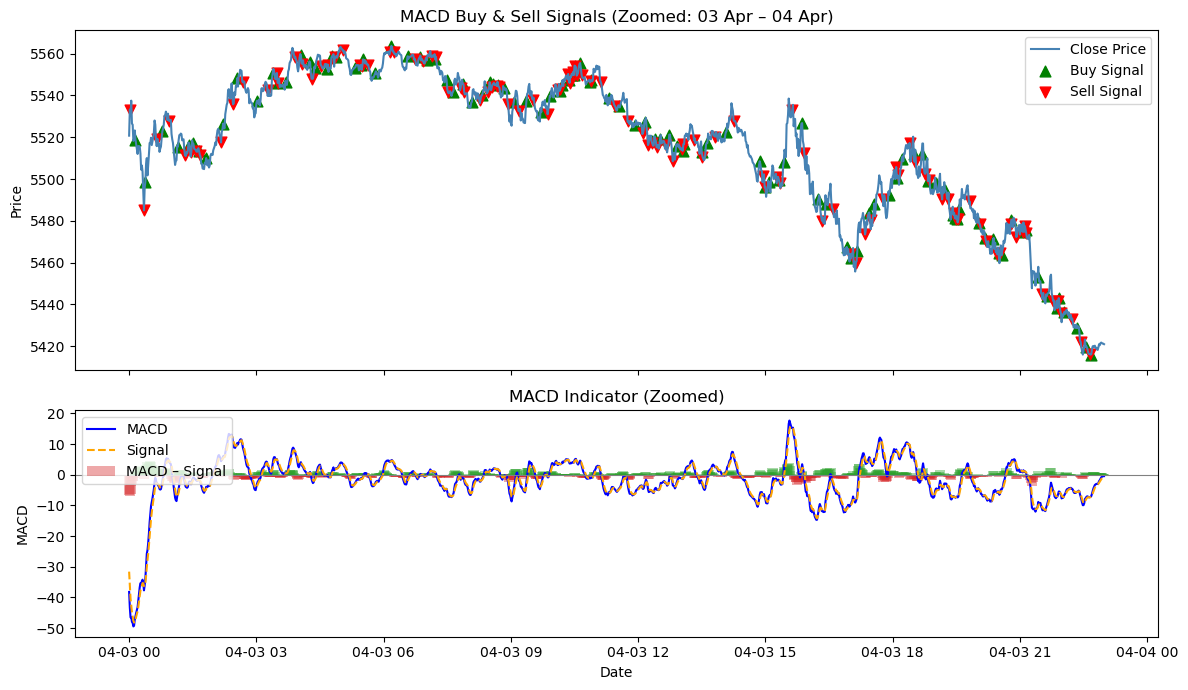

In [10]:
# ── MACD Visualisation for 03–04 Apr ────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ── 1. Load and Prepare Data ────────────────────────────────────────
df = pd.read_csv("combined_all_three.csv", parse_dates=["timestamp"]).set_index("timestamp")

# ── 2. MACD Parameters ──────────────────────────────────────────────
FAST, SLOW, SIG = 6, 32, 4  # ← you can adjust these if needed

# ── 3. Compute Indicators and Signals ───────────────────────────────
df_macd = df.copy()
df_macd["EMA_fast"]  = df_macd["close"].ewm(span=FAST, adjust=False).mean()
df_macd["EMA_slow"]  = df_macd["close"].ewm(span=SLOW, adjust=False).mean()
df_macd["MACD"]      = df_macd["EMA_fast"] - df_macd["EMA_slow"]
df_macd["MACD_sig"]  = df_macd["MACD"].ewm(span=SIG, adjust=False).mean()
df_macd["MACD_hist"] = df_macd["MACD"] - df_macd["MACD_sig"]

# ── 4. Identify Signal Crossovers ───────────────────────────────────
df_macd["Position"] = np.sign(df_macd["MACD"] - df_macd["MACD_sig"]).shift()
cross = df_macd["Position"].diff().fillna(0)
buy_idx  = cross[cross ==  2].index  # −1 → +1
sell_idx = cross[cross == -2].index  # +1 → −1

# ── 5. Restrict to Zoom Window ──────────────────────────────────────
mask = (df_macd.index >= "2025-04-03") & (df_macd.index < "2025-04-04")
z = df_macd.loc[mask]

# ── 6. Plot Price and Signals ───────────────────────────────────────
fig, (ax_price, ax_macd) = plt.subplots(2, 1, figsize=(12, 7), sharex=True,
                                        gridspec_kw={"height_ratios":[3,2]})

# Price panel
ax_price.plot(z.index, z["close"], label="Close Price", color="steelblue")
ax_price.scatter(z.loc[buy_idx.intersection(z.index)].index,
                 z.loc[buy_idx.intersection(z.index), "close"],
                 marker="^", color="green", s=60, label="Buy Signal")
ax_price.scatter(z.loc[sell_idx.intersection(z.index)].index,
                 z.loc[sell_idx.intersection(z.index), "close"],
                 marker="v", color="red", s=60, label="Sell Signal")
ax_price.set_title("MACD Buy & Sell Signals (Zoomed: 03 Apr – 04 Apr)")
ax_price.set_ylabel("Price")
ax_price.legend()

# MACD panel
ax_macd.plot(z.index, z["MACD"], label="MACD", color="blue")
ax_macd.plot(z.index, z["MACD_sig"], label="Signal", color="orange", ls="--")
ax_macd.bar(z.index, z["MACD_hist"], label="MACD – Signal", width=0.01,
            color=np.where(z["MACD_hist"] >= 0, "tab:green", "tab:red"), alpha=0.4)
ax_macd.axhline(0, color="grey", lw=0.8)
ax_macd.set_title("MACD Indicator (Zoomed)")
ax_macd.set_ylabel("MACD")
ax_macd.legend(loc="upper left")

plt.xlabel("Date")
plt.tight_layout()
plt.show()
